In [1]:
import pandas as pd
import numpy as np
import torch
import os
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split, prepare_k_fold_federated_dataset
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_unsupervised, train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix, calculate_unsupervised_metrics
from utils.utils_metrics import compute_bic

C:\Users\mihao\AppData\Local\Temp\ipykernel_7528\2526094095.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from model.eFedGauss import eFedGauss

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
#if torch.cuda.is_available():
#    device = torch.device("cuda")
#    print("CUDA is available. Using GPU.")
#else:
device = torch.device("cpu")
print("CUDA not available. Using CPU.")

# Model parameters
local_model_params = {
    "feature_dim": 2,
    "num_classes": 3,
    "kappa_n": 1,
    "num_sigma": 2,
    "kappa_join": 0.5,
    "S_0": 1e-8,
    "N_r": 8,
    "c_max": 10000,
    "device": device
}
federated_model_params = {
    "feature_dim": 2,
    "num_classes": 3,
    "kappa_n": 1,
    "num_sigma": 3,
    "kappa_join": 0.9,
    "S_0": 1e-8,
    "N_r": 8,
    "c_max": 10000,
    "device": device
}

PyTorch Version: 2.2.0
CUDA Version: 11.8
CUDA not available. Using CPU.


In [3]:
# Generate the data as provided

z_1_top = 1*np.random.randn(1, 200)
z_1 = np.vstack((z_1_top, z_1_top + (0.8 * np.random.randn(1, 200))))
z_2_top = np.random.randn(1, 200)
z_2 = np.vstack((z_2_top, -z_2_top + (8 + 0.85 * np.random.randn(1, 200))))
z_3_top = -1.5 + 0.5 * np.random.randn(1, 200)
z_3 = np.vstack((z_3_top, -z_3_top + (4 + 0.5 * np.random.randn(1, 200))))

labels_1 = 0*np.ones((z_1.shape[1],), dtype=np.int32)  # Label 0 for z_1 cluster
labels_2 = 1*np.ones((z_2.shape[1],), dtype=np.int32)  # Label 1 for z_2 cluster
labels_3 = 2*np.ones((z_3.shape[1],), dtype=np.int32)  # Label 2 for z_3 cluster

# Concatenate the data and labels
z = np.hstack((z_1, z_2, z_3))
labels = np.hstack((labels_1, labels_2, labels_3))

# Shuffle the data and labels in the same order
indices = np.random.permutation(z.shape[1])
data = z[:, indices].transpose()
labels = labels[indices]


Experiment with 1 clients and 100% data per client
Repetition 1/10 for 1 clients and 100% data
*** Repetition 1/10. Start of fold 0 for 1 clients and 100% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 18
Updated var_glo values: tensor(1.2019)
Number of clusters after merging = 9
Evolving has been disabled.
*** Repetition 1/10. Start of fold 1 for 1 clients and 100% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 15
Updated var_glo values: tensor(1.1894)
Number of clusters after merging = 7
Evolving has been disabled.
*** Repetition 1/10. Start of fold 2 for 1 clients and 100% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 16
Updated var_glo values: tensor(1.1881)
Number of clusters after merging = 9
Evolving has been disabled.
Repetition

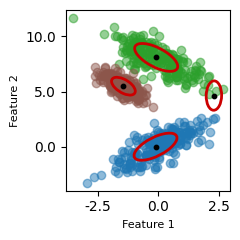

Evolving has been disabled.

Experiment with 3 clients and 10.0% data per client
Repetition 1/10 for 3 clients and 10.0% data
*** Repetition 1/10. Start of fold 0 for 3 clients and 10.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 10
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 10
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 10
Updated var_glo values: tensor(1.2082)
Updated var_glo values: tensor(1.2095)
Updated var_glo values: tensor(1.1735)
Number of clusters after merging = 3
Evolving has been disabled.
*** Repetition 1/10. Start of fold 1 for 3 clients and 10.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 10
Training model for client 2
Evolving has been enabled.
Number of clusters 

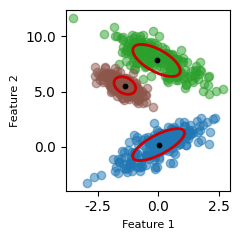

Evolving has been disabled.

Experiment with 3 clients and 20.0% data per client
Repetition 1/10 for 3 clients and 20.0% data
*** Repetition 1/10. Start of fold 0 for 3 clients and 20.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 11
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 12
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 15
Updated var_glo values: tensor(1.3413)
Updated var_glo values: tensor(1.1963)
Updated var_glo values: tensor(1.1595)
Number of clusters after merging = 4
Evolving has been disabled.
*** Repetition 1/10. Start of fold 1 for 3 clients and 20.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 12
Training model for client 2
Evolving has been enabled.
Number of clusters 

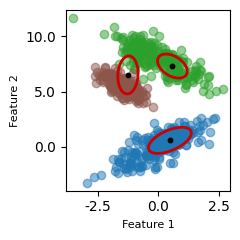

Evolving has been disabled.

Experiment with 3 clients and 33.0% data per client
Repetition 1/10 for 3 clients and 33.0% data
*** Repetition 1/10. Start of fold 0 for 3 clients and 33.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 11
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 14
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 15
Updated var_glo values: tensor(1.2904)
Updated var_glo values: tensor(1.1865)
Updated var_glo values: tensor(1.1538)
Number of clusters after merging = 5
Evolving has been disabled.
*** Repetition 1/10. Start of fold 1 for 3 clients and 33.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 20
Training model for client 2
Evolving has been enabled.
Number of clusters 

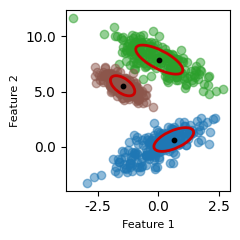

Evolving has been disabled.

Experiment with 5 clients and 10.0% data per client
Repetition 1/10 for 5 clients and 10.0% data
*** Repetition 1/10. Start of fold 0 for 5 clients and 10.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 10
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 11
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 10
Training model for client 4
Evolving has been enabled.
Number of clusters with multiple samples for Client 4 = 9
Training model for client 5
Evolving has been enabled.
Number of clusters with multiple samples for Client 5 = 7
Updated var_glo values: tensor(0.9556)
Updated var_glo values: tensor(1.0114)
Updated var_glo values: tensor(1.1498)
Updated var_glo values: tensor(1.1950)
Updated var_glo values: tensor(1.2063)
Number of clusters after mergi

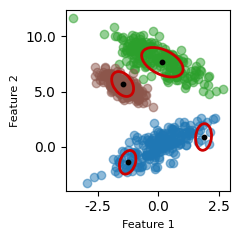

Evolving has been disabled.

Experiment with 10 clients and 10.0% data per client
Repetition 1/10 for 10 clients and 10.0% data
*** Repetition 1/10. Start of fold 0 for 10 clients and 10.0% data per client ***
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 7
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 7
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 9
Training model for client 4
Evolving has been enabled.
Number of clusters with multiple samples for Client 4 = 10
Training model for client 5
Evolving has been enabled.
Number of clusters with multiple samples for Client 5 = 10
Training model for client 6
Evolving has been enabled.
Number of clusters with multiple samples for Client 6 = 9
Training model for client 7
Evolving has been enabled.
Number of clusters with multiple samples for Client 7 =

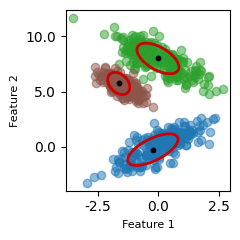

Evolving has been disabled.


In [4]:
X = data
y = labels
num_splits = 3

# Define the configurations for the experiment
num_clients_options = [1, 3, 5, 10]  # Number of clients
data_percentage_options = [0.1, 0.2, 0.33, 1]  # Percentage of data for each client

# Define the specific configurations of interest
specific_configurations = [
    (1, 1), 
    (3, 0.10), (5, 0.10), (10, 0.10),  # 10% data for 3, 5, and 10 clients
    (3, 0.20), (3, 0.33)              # 20% and 33% data for 3 clients
]

# Placeholder for results
experiment_results = []

# Number of repetitions for each configuration
num_repetitions = 10

# Loop over the different configurations
for num_clients in num_clients_options:
    for data_percentage in data_percentage_options:
        if (num_clients, data_percentage) in specific_configurations:
            print(f"\nExperiment with {num_clients} clients and {data_percentage*100}% data per client")

            # Initialize result containers for this configuration
            config_results = {
                "client_clusters": [],
                "aggregated_clusters": [],
                "federated_metrics": [],
                "federated_clusters": [],
                "num_of_samples": []
            }

            for repetition in range(num_repetitions):
                print(f"Repetition {repetition + 1}/{num_repetitions} for {num_clients} clients and {data_percentage*100}% data")

                kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

                # Initialize arrays to track samples per class for each client in each fold
                samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

                # Main loop for k-fold cross-validation
                #all_client_metrics = [[] for _ in range(num_clients)]
                all_client_clusters = [[] for _ in range(num_clients)]
                all_agregated_clusters = []
                all_federated_metrics = []
                all_federated_clusters = []

                # K-Fold Cross-Validation
                for i_fold, (train_index, test_index) in enumerate(kf.split(data)):
                    print(f"*** Repetition {repetition + 1}/{num_repetitions}. Start of fold {i_fold} for {num_clients} clients and {data_percentage*100}% data per client ***")

                    # Split the data based on the current configuration
                    train_data, test_data, all_data = prepare_k_fold_federated_dataset(
                        X, y, train_index, test_index, num_clients, data_percentage)
                    
                    local_models = [eFedGauss(**local_model_params) for _ in range(num_clients)]
                    federated_model = eFedGauss(**federated_model_params)

                    #federated_model.toggle_debugging(True)
                    
                    #Train the models
                    for client_idx, client_model in enumerate(local_models):
                        #client_model.toggle_debugging(True)

                        # Count the number of samples per class for this client in this fold
                        for class_idx in range(client_model.num_classes):
                            class_samples = torch.sum(train_data[client_idx][1] == class_idx)
                            samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

                        #unsupervised clustering
                        print(f"Training model for client {client_idx + 1}")
                        train_unsupervised(client_model, train_data[client_idx]) 

                        #Test the local models

                        #Save the number of clusters
                        num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
                        print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
                        all_client_clusters[client_idx].append(num_client_clusters)

                    #Aggregate local models
                    for client_idx, client_model in enumerate(local_models):
                        federated_model.federal_agent.merge_model_privately(client_model, n_min=0, pred_min=0)
                        num_agregated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                        all_agregated_clusters.append(num_agregated_clusters)

                    #Merge the federated model clusters
                    #print(f"\nNumber of clusters after transfer = {federated_model.c}")
                    federated_model.federal_agent.federated_merging()

                    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                    print(f"Number of clusters after merging = {federated_model.c}")
                    all_federated_clusters.append(num_federated_clusters)
                    
                    #Plot the Aggregated model
                    '''
                    if num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="Aggregated models")   
                        save_figure(fig, "Images/synthetic_federated_pre_merge.svg","svg")
                        save_figure(fig, "Images/synthetic_federated_pre_merge.pdf","pdf")
                    '''
                    if repetition == num_repetitions-1 and i_fold == (num_splits-1): 
                        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=1, title="")  
                        
                    #Test the federated model
                    #calculate_unsupervised_metrics()
                    _,_, cluster_assignment = test_model(federated_model, test_data)

                    federated_metrics = calculate_unsupervised_metrics(cluster_assignment.cpu(), test_data)
                    #num_params = federated_model.c*(federated_model.feature_dim**2 + federated_model.feature_dim +1)
                    #bic = compute_bic(cluster_assignment.detach().numpy(), num_params)
                    all_federated_metrics.append(federated_metrics)
                    #all_federated_bic.append(bic)
                    
                # Collect results for this repetition
                config_results["client_clusters"].append(all_client_clusters)
                config_results["aggregated_clusters"].append(all_agregated_clusters)
                config_results["federated_metrics"].append(all_federated_metrics)
                config_results["federated_clusters"].append(all_federated_clusters)
                config_results["num_of_samples"].append(samples_per_class_per_client)

            # After all repetitions, append the summarized results
            experiment_results.append({
                "num_clients": num_clients,
                "data_percentage": data_percentage,
                **config_results
            })


Non-IID Experiment with 3 clients and 33.0% data per client
Repetition 1/10 for 3 clients and 33.0% data
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 16
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 10
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 16
Updated var_glo values: tensor(1.2522)
Updated var_glo values: tensor(1.1116)
Updated var_glo values: tensor(1.1108)
Number of clusters after merging = 7
Evolving has been disabled.
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 15
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 11
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 18
Updated var_glo values: tens

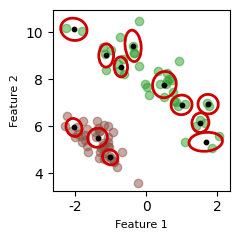

Figure saved as .Images/synthetic_local_model_1.svg in svg format.
Figure saved as .Images/synthetic_local_model_1.pdf in pdf format.
Updated var_glo values: tensor(1.2080)


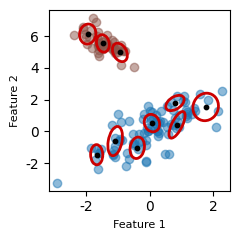

Figure saved as .Images/synthetic_local_model_2.svg in svg format.
Figure saved as .Images/synthetic_local_model_2.pdf in pdf format.
Updated var_glo values: tensor(1.1317)


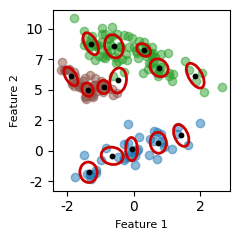

Figure saved as .Images/synthetic_local_model_3.svg in svg format.
Figure saved as .Images/synthetic_local_model_3.pdf in pdf format.


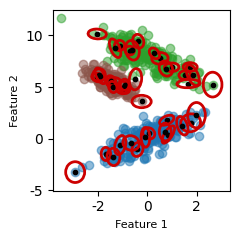

Figure saved as .Images/synthetic_federated_pre_merge.svg in svg format.
Figure saved as .Images/synthetic_federated_pre_merge.pdf in pdf format.
Number of clusters after merging = 7


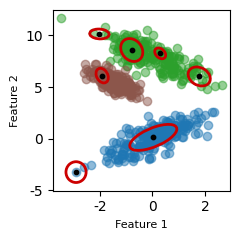

Figure saved as .Images/synthetic_federated.svg in svg format.
Figure saved as .Images/synthetic_federated.pdf in pdf format.
Evolving has been disabled.

Non-IID Experiment with 5 clients and 20.0% data per client
Repetition 1/10 for 5 clients and 20.0% data
Training model for client 1
Evolving has been enabled.
Number of clusters with multiple samples for Client 1 = 11
Training model for client 2
Evolving has been enabled.
Number of clusters with multiple samples for Client 2 = 11
Training model for client 3
Evolving has been enabled.
Number of clusters with multiple samples for Client 3 = 13
Training model for client 4
Evolving has been enabled.
Number of clusters with multiple samples for Client 4 = 12
Training model for client 5
Evolving has been enabled.
Number of clusters with multiple samples for Client 5 = 12
Updated var_glo values: tensor(1.0660)
Updated var_glo values: tensor(1.0941)
Updated var_glo values: tensor(1.1047)
Updated var_glo values: tensor(1.1645)
Updated var_gl

In [5]:
# Non IID experiment
# Define the specific configurations of interest
specific_configurations = [
    (3, 0.33), (5, 0.20), (10, 0.10),  # 10% data for 3, 5, and 10 clients
]

experiment_non_iid_results = []

os.makedirs(".Images", exist_ok=True)  # Create the directory to save the images if it doesn't exist

# Loop over the different configurations
for num_clients in num_clients_options:
    for data_percentage in data_percentage_options:
        if (num_clients, data_percentage) in specific_configurations:
            print(f"\nNon-IID Experiment with {num_clients} clients and {data_percentage*100}% data per client")

            # Initialize result containers for this configuration
            config_results = {
                "client_clusters": [],
                "aggregated_clusters": [],
                "federated_metrics": [],
                "federated_clusters": [],
                "num_of_samples": []
            }

            for repetition in range(num_repetitions):
                print(f"Repetition {repetition + 1}/{num_repetitions} for {num_clients} clients and {data_percentage*100}% data")

                # Main loop for k-fold cross-validation
                #all_client_metrics = [[] for _ in range(num_clients)]
                all_client_clusters = [[] for _ in range(num_clients)]
                all_agregated_clusters = []
                all_federated_metrics = []
                all_federated_clusters = []

                # Initialize K-Fold outside the repetition loop
                kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

                # Initialize arrays to track samples per class for each client in each fold
                samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

                # K-Fold Cross-Validation for each repetition
                for i_fold, (train_index, test_index) in enumerate(kf.split(data)):

                    # Split the data based on the current configuration
                    train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(
                        X, y, train_index, test_index, num_clients)
                    
                    #Create the models
                    local_models = [eFedGauss(**local_model_params) for _ in range(num_clients)]
                    federated_model = eFedGauss(**federated_model_params)
                    #federated_model.toggle_debugging(True)
                    
                    #Train the models
                    for client_idx, client_model in enumerate(local_models):
                        #client_model.toggle_debugging(True)

                        # Count the number of samples per class for this client in this fold
                        for class_idx in range(client_model.num_classes):
                            class_samples = torch.sum(train_data[client_idx][1] == class_idx)
                            samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

                        #unsupervised clustering
                        print(f"Training model for client {client_idx + 1}")
                        train_unsupervised(client_model, train_data[client_idx]) 

                        #Test the local models

                        #Save the number of clusters
                        num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
                        print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
                        all_client_clusters[client_idx].append(num_client_clusters)

                    #Aggregate local models
                    for client_idx, client_model in enumerate(local_models):
                        federated_model.federal_agent.merge_model_privately(client_model, n_min=0, pred_min=0)
                        num_agregated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                        all_agregated_clusters.append(num_agregated_clusters)

                        #Plot local models
                        
                        if repetition == (num_repetitions-1) and num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                                
                            #Plot the local models
                            fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="", format="%d")  #f"Local model {client_idx+1}"
                            save_figure(fig, f".Images/synthetic_local_model_{client_idx+1}.svg", "svg")
                            save_figure(fig, f".Images/synthetic_local_model_{client_idx+1}.pdf","pdf")
                        

                    #Plot the Aggregated model
                    if repetition == (num_repetitions-1) and num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="", format="%.0f")   
                        save_figure(fig, ".Images/synthetic_federated_pre_merge.svg","svg")
                        save_figure(fig, ".Images/synthetic_federated_pre_merge.pdf","pdf")
                    
                    #Merge the federated model clusters
                    #print(f"\nNumber of clusters after transfer = {federated_model.c}")
                    federated_model.federal_agent.federated_merging()
                    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()
                    print(f"Number of clusters after merging = {federated_model.c}")
                    all_federated_clusters.append(num_federated_clusters)
                    
                    #Plot the Aggregated model
                    if repetition == (num_repetitions-1) and num_clients == 3 and  data_percentage == 0.33 and i_fold == (num_splits-1):
                        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="", format="%.0f")   
                        save_figure(fig, ".Images/synthetic_federated.svg","svg")
                        save_figure(fig, ".Images/synthetic_federated.pdf","pdf")
                        
                    #Test the federated model
                    #calculate_unsupervised_metrics()
                    _,_, cluster_assignment = test_model(federated_model, test_data)

                    federated_metrics = calculate_unsupervised_metrics(cluster_assignment.cpu(), test_data)
                    #num_params = federated_model.c*(federated_model.feature_dim**2 + federated_model.feature_dim +1)
                    #bic = compute_bic(cluster_assignment.detach().numpy(), num_params)
                    all_federated_metrics.append(federated_metrics)
                    #all_federated_bic.append(bic)
                    
                # Collect results for this repetition
                config_results["client_clusters"].append(all_client_clusters)
                config_results["aggregated_clusters"].append(all_agregated_clusters)
                config_results["federated_metrics"].append(all_federated_metrics)
                config_results["federated_clusters"].append(all_federated_clusters)
                config_results["num_of_samples"].append(samples_per_class_per_client)

            # After all repetitions, append the summarized results
            experiment_non_iid_results.append({
                "num_clients": num_clients,
                "data_percentage": data_percentage,
                **config_results
            })

In [6]:
#Aditional plots of the data
'''
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/synthetic_data_distribution.svg","svg")
save_figure(fig, "Images/synthetic_data_distribution.pdf","pdf")
'''

'\ndisplay_dataset_split(train_data, test_data)\nfig = plot_dataset_split(train_data, test_data)\nsave_figure(fig, "Images/synthetic_data_distribution.svg","svg")\nsave_figure(fig, "Images/synthetic_data_distribution.pdf","pdf")\n'

In [7]:
# Define the LaTeX table header and footer
table_header = r'''\begin{table}[ht]
\centering
\setlength{\tabcolsep}{3pt}
\scriptsize
\caption{Unsupervised Clustering for Different Client Data Distributions}
\begin{tabular}{lcccccc}
\toprule
\textbf{\#Clients/Data}&\textbf{\#Local$\downarrow$}&\textbf{\#Aggre.$\downarrow$}&\textbf{\#Fed.$\downarrow$}&\textbf{S$\uparrow$}&\textbf{ARI$\uparrow$}&\textbf{V$\uparrow$}\\ 
\midrule
'''
import numpy as np

def format_row(num_clients, data_percentage, results_list, best_values):
    # Function to format a metric with highlighting if it's the best
    def format_metric(metric_value, metric_name):
        if metric_value == best_values[metric_name]:
            return r"\textbf{" + f"{metric_value}" + "}"
        else:
            return f"{metric_value}"

    # Check if results_list contains only one element
    results = results_list[0]

    # Use the metrics and cluster stats from this single result
    avg_std_fed_metrics = calculate_metrics_statistics(results['federated_metrics'])

    silhouette_score = format_metric(avg_std_fed_metrics["silhouette_score"], "silhouette_score")
    ari_score = format_metric(avg_std_fed_metrics["adjusted_rand_score"], "ari_score")
    v_measure_score = format_metric(avg_std_fed_metrics['v_measure_score'], "v_measure_score")

    client_clusters = [cluster for client in results['client_clusters'] for cluster in client]
    local_clusters, std_local_clusters = calculate_cluster_stats(client_clusters)

    aggre_clusters, std_aggre_clusters = calculate_cluster_stats(results['aggregated_clusters'])
    fed_clusters, std_fed_clusters = calculate_cluster_stats(results['federated_clusters'])

    # Format cluster data
    local_clusters_str = f"{local_clusters:.1f}±{std_local_clusters:.1f}"
    aggre_clusters_str = f"{aggre_clusters:.1f}±{std_aggre_clusters:.1f}"
    fed_clusters_str = f"{fed_clusters:.1f}±{std_fed_clusters:.1f}"

    # Compute average number of samples
    samples = f"{int(np.mean(results['num_of_samples'])):d}"

    # Format and return the row string
    return f"{num_clients}/{int(data_percentage * 100)}\%({samples})&{local_clusters_str}&{aggre_clusters_str}&{fed_clusters_str}&{silhouette_score}&{ari_score}&{v_measure_score}\\\\"

def generate_table_rows(experiments, part_filter):
    # Collect all metrics for determining the best values
    metrics_data = {
        "silhouette_score": [],
        "ari_score": [],
        "v_measure_score": [],
        # Add other metrics as needed
    }

    # Initialize a dictionary to group results by configuration
    grouped_results = {}

    # Group results by configuration and aggregate metrics
    for config in experiments:
        if part_filter(config):
            config_key = (config['num_clients'], config['data_percentage'])
            if config_key not in grouped_results:
                grouped_results[config_key] = []
            grouped_results[config_key].append(config)

            # Aggregate metrics for determining the best values
            avg_std_fed_metrics = calculate_metrics_statistics(config['federated_metrics'])
            metrics_data["silhouette_score"].append(avg_std_fed_metrics["silhouette_score"])
            metrics_data["ari_score"].append(avg_std_fed_metrics["adjusted_rand_score"])
            metrics_data["v_measure_score"].append(avg_std_fed_metrics['v_measure_score'])

    # Determine best values for each metric
    best_values = {metric: max(values) for metric, values in metrics_data.items()}

    # Generate rows with highlighting
    table_rows = ""
    for (num_clients, data_percentage), configs in grouped_results.items():
        table_rows += format_row(num_clients, data_percentage, configs, best_values) + "\n"

    return table_rows

# Define filters for each part of the table
def is_part0(config):
    # Part 1: Experiments with data_percentage of 0.1
    return config['data_percentage'] == 1

# Define filters for each part of the table
def is_part1(config):
    # Part 1: Experiments with data_percentage of 0.1
    return config['data_percentage'] == 0.1

def is_part2(config):
    # Part 2: Experiments with 3 clients
    return config['num_clients'] == 3

def is_part3(config):
    """Check if the given configuration matches any in the non-IID experiment results."""
    return True

# Define the table footer
table_footer = r'''\bottomrule
\multicolumn{7}{p{0.95\linewidth}}{\tiny\textbf{Note:} The first column displays the number of clients, available data as a percentage of the entire training dataset, and the actual number of samples. The number symbol (\#) denotes the count of local (\#Local), aggregated (\#Aggre.), and federated (\#Fed.) clusters. Clustering evaluation metrics used in the table include the Silhouette score (S), Adjusted Rand Index (ARI), and V-Measure (V).}
\end{tabular}
\label{tab:unsupervised_metrics}
\end{table}'''

# Create rows for each part
part0_rows = generate_table_rows(experiment_results, is_part0)
part1_rows = r'''\midrule
\multicolumn{7}{l}{\textbf{Experiment 1: Influence of Number of Clients with Equal Data Size}} \\
''' + generate_table_rows(experiment_results, is_part1)
part2_rows = r'''\midrule
\multicolumn{7}{l}{\textbf{Experiment 2: Influence of Data Percentage per Client}} \\
''' + generate_table_rows(experiment_results, is_part2)
part3_rows = r'''\midrule
\multicolumn{7}{l}{\textbf{Experiment 3: Influence of Number of Clients with Non-IID Data}} \\
''' + generate_table_rows(experiment_non_iid_results, is_part3)

# Combine and output the final LaTeX table
latex_table = table_header + part0_rows + part1_rows + part2_rows + part3_rows + table_footer
print(latex_table)

\begin{table}[ht]
\centering
\setlength{\tabcolsep}{3pt}
\scriptsize
\caption{Unsupervised Clustering for Different Client Data Distributions}
\begin{tabular}{lcccccc}
\toprule
\textbf{\#Clients/Data}&\textbf{\#Local$\downarrow$}&\textbf{\#Aggre.$\downarrow$}&\textbf{\#Fed.$\downarrow$}&\textbf{S$\uparrow$}&\textbf{ARI$\uparrow$}&\textbf{V$\uparrow$}\\ 
\midrule
1/100\%(133)&17.2±1.6&17.2±1.6&6.2±1.6&\textbf{0.42{±}0.05}&\textbf{0.80{±}0.10}&\textbf{0.84{±}0.06}\\
\midrule
\multicolumn{7}{l}{\textbf{Experiment 1: Influence of Number of Clients with Equal Data Size}} \\
3/10\%(13)&9.5±1.5&18.9±8.2&3.9±1.1&\textbf{0.43{±}0.07}&\textbf{0.81{±}0.13}&\textbf{0.83{±}0.10}\\
5/10\%(13)&9.4±1.4&28.1±13.5&3.3±0.7&0.39{±}0.15&0.75{±}0.27&0.79{±}0.22\\
10/10\%(13)&9.2±1.4&51.1±26.5&3.7±1.0&0.38{±}0.14&0.75{±}0.25&0.78{±}0.20\\
\midrule
\multicolumn{7}{l}{\textbf{Experiment 2: Influence of Data Percentage per Client}} \\
3/10\%(13)&9.5±1.5&18.9±8.2&3.9±1.1&\textbf{0.43{±}0.07}&0.81{±}0.13&0.83{±}0